# MLINDIV Functional Connectivity Example
## Using Subject 033's Explore Session 1 Functional Data, and the Harvard-Oxford Subcortical Atlas

In this example, I go through the process of using Nilearn's powerful masker object to calculate fairly complex operations and output a functional connectivity matrix. We then visualize that matrix at the end. To summarize the steps, we:
 - Import necessary modules and functions
 - Locate/load the functional images, and store relevant data
 - Construct a Nilearn Masker Object (Mask) to label our data according to some pre-labeled atlas (Harvard-Oxford)
 - Apply the Mask to our functional data to obtain a time-series of functional regions during the task
 - Calculate a Connectivity Matrix out of the new time-series (Correlate each functional region to each other functional region), and plot it.


### Import Modules & Functions
This is necessary.

In [1]:
import numpy as np
import nibabel as nib
import pandas
import os.path
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

### Load Functional Images, Store Relevant Data
Here we load the Harvard-Oxford Atlas. Specifically the subcortical max probability atlas with a 2mm voxel size. Nilearn actually houses all the HO atlases so we call the datasets.fetch_atlas_harvard_oxford function to grab the one we want. We store its labels for later use. 

We then load our functional data; save the voxel size and TR for later. Here we also use the pandas module to load in the confounds, replace the NaN values with 0, and then save to conf_nona_filename. This makes the Mask operation later run without erroring out.

In [2]:
dataset = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

mlindiv_filename = 'D:/SampleData/sub-033_task-boldEx_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
confounds_filename = 'D:/SampleData/sub-033_task-boldEx_run-1_conformatted.tsv'
conf_nona_filename = "D:/SampleData/sub033_Ex1_conf_nona.tsv"

func_img = nib.load(mlindiv_filename)
header_zooms = func_img.header.get_zooms()
TR = header_zooms[3]

pandas.read_csv(confounds_filename, sep = '\t').fillna(0).to_csv(conf_nona_filename, sep = '\t', index = False)

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)
print('Func images are located in nifti image (4D) at: %s \n\t--- Confounds at: %s \n\t--- Confounds w/out NaNs: %s' % (mlindiv_filename, confounds_filename, conf_nona_filename))
print('Func images Voxel Dimensions (mm): %s\tFunc TR: %s' % (header_zooms[0:3], header_zooms[3]))

Atlas ROIs are located in nifti image (4D) at: C:\Users\17868/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-sub-maxprob-thr25-2mm.nii.gz
Func images are located in nifti image (4D) at: D:/SampleData/sub-033_task-boldEx_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz 
	--- Confounds at: D:/SampleData/sub-033_task-boldEx_run-1_conformatted.tsv 
	--- Confounds w/out NaNs: D:/SampleData/sub033_Ex1_conf_nona.tsv
Func images Voxel Dimensions (mm): (2.0, 2.0, 2.0)	Func TR: 0.72


### Construct the Mask and Create the Time-Series
Now we take the HO atlas and its labels, as well as some filtering parameters, and build a mask object out of them. We then take the mask (masker) and fit our functional data to it. This will parcellate our functional data into the regions labeled by the HO atlas, filter some noise out, and regress out the confounds we've provided (csf, body movement, etc.). What we are left with is a time series for each functional region, that we then store for the next step.

In [3]:
masker = NiftiLabelsMasker(labels_img = atlas_filename, standardize=True, memory = 'nilearn_cache', verbose = 5, 
                          low_pass=0.08, high_pass=0.009, detrend=True, t_r = TR)

time_series = masker.fit_transform(mlindiv_filename, confounds = conf_nona_filename)

[NiftiLabelsMasker.fit_transform] loading data from C:\Users\17868/nilearn_data\fsl\data\atlases\HarvardOxford\HarvardOxford-sub-maxprob-thr25-2mm.nii.gz
Resampling labels
[Memory]0.6s, 0.0min    : Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


#### To help visualize: 
I've plotted the BOLD signal from the 4th functional region of interest (ROI) below, which is the Left Thalamus. This is it's activity across the first explore session for subject 33. 

What we will do next is take all 21 ROIs and correlate their BOLD signal time-series with each other. This gives us a correlation matrix that we can also visualize.

(674, 21)

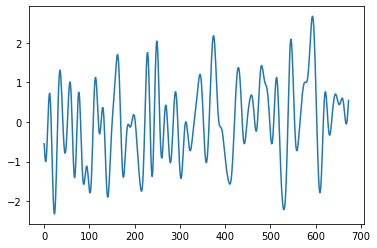

In [4]:
import matplotlib.pyplot as plt
plt.plot(time_series[:, 3])
time_series.shape

### Calculate the Functional Conenctivity Matrix
Below we will initialize a type of connectivity measure, of type 'correlation'. We then apply that measure to the whole time-series, fill the diagonal with zeros (as we don't care about how correlated an ROI is to itself), and plot  the result!

Voila, a functional connectivity matrix!

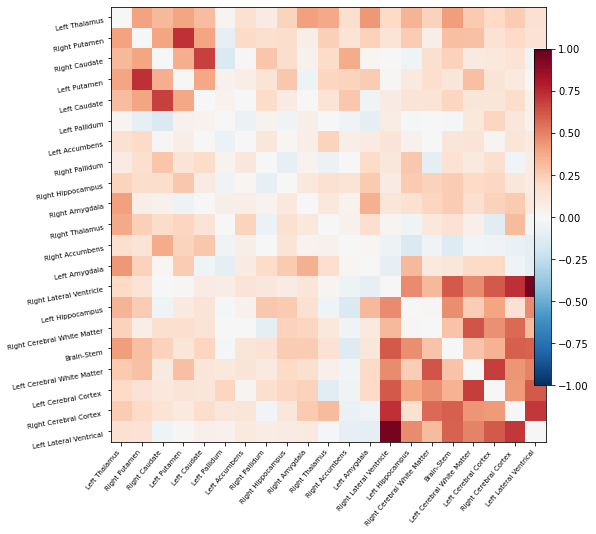

In [101]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels[1:],
                     vmax=1, vmin=-1, reorder=True)